<a href="https://colab.research.google.com/github/OsmanCanCetlenbik/osmancancetlenbik/blob/master/Email_Classification_Using_Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

OVERVIEW:

In this tutorial notebook, we will be covering a simple approach to email classification(spam or not spam) using BERT

Steps are:
- We will load our data - mainly sentences and labels-span or not spam
- Load these in bert to generate an contextualized embedding vector of length 768

- - We will first apply preprocessing using the preprocessor object , refer the documentation

- - We will pass this preprocessed text to our model to generate the contexutailized embedding vector


- Finally pass this embedding vector to single neuron in output to do binary classificaton

- For maximizing performance we will be balancing our dataset and use a dropout layer to regularize the model and prevent overfitting

# Loading Dependencies

Includes
- Tensorflow_hub : Place where all tenseorflow pretrained models are stored.
- Pandas : For data loading, manipulation and wrangling.
- Tensorflow_text : Allows addditional NLP text processing capablities outside scope of tensorflow
- Skelarn : For doing data evaluation and splitting
- Matplotlib : For visualization

In [1]:
# installing tensorflow_text
!pip install tensorflow-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 78.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 75.9 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalled tensorboard-2.14.1
  Attempting uninstall: tensorflow
    Found existing install

In [9]:
pip install --upgrade pandas


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 32.4 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.1.3 which is incompatible.


In [10]:
import tensorflow_hub as hub
import pandas as pd
import tensorflow_text as text
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np


# Loading Data

- Read Data
- Display data
USING PANDAS

In [21]:
import csv
import pandas as pd

# Alan boyutu sınırlamasını arttır
csv.field_size_limit(100000000)  # Bu değeri ihtiyaca göre ayarlayabilirsiniz

with open('/content/Phishing_Email.csv', 'r', encoding=result['encoding'], errors='replace') as file:
    reader = csv.reader(file)
    df = pd.DataFrame(reader)



In [22]:
df.head()

,0,1,2
0,,Email Text,Email Type
1,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
2,1,the other side of * galicismos * * galicismo *...,Safe Email
3,2,re : equistar deal tickets are you still avail...,Safe Email
4,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email


# Data Analysis

- Check the description by grouping by category :
* no of data points for each category - count
* no of unique values in each category - unique




In [29]:
import pandas as pd

# DataFrame'i oluştururken sütun adlarını manuel olarak belirtin
df = pd.read_csv('/content/Phishing_Email.csv', names=['Email Text', 'Email Type'])

# 'Email Type' sütunundaki değerlerin frekanslarını kontrol edin
df['Email Type'].value_counts()


Safe Email        11322
Phishing Email     7328
Email Type            1
Name: Email Type, dtype: int64

**Clearly dataset is imbalanced - not so much but still it can affect our model. Need to use some type of regulariztion like downsampling dataset for mazority class**

# Downsampling Dataset

**Includes:**
- Check percentage of unbalances.
- Creating 2 new dataframes out of existing one.
- Taking any random minority no of samples - `(747)` for majority class`(4825)`.
- Creating a balanced dataset by concating 2 new data frames.

In [30]:
# check percentange of data - states how much data needs to be balanced
str(round(747/4825,2))+'%'

'0.15%'

In [31]:
# creating 2 new dataframe as df_ham , df_spam

df_phishing = df[df['Email Type']=='Phishing Email']
print("Phishing Dataset Shape:", df_phishing.shape)

df_safe = df[df['Email Type']=='Safe Email']
print("Safe Dataset Shape:", df_safe.shape)

Phishing Dataset Shape: (7328, 2)
Safe Dataset Shape: (11322, 2)


In [33]:
# downsampling ham dataset - take only random 747 example
# will use df_spam.shape[0] - 747

df_safe_downsampled = df_safe.sample(df_phishing.shape[0])
df_safe_downsampled.shape

(7328, 2)

In [34]:
# concating both dataset - df_spam and df_ham_balanced to create df_balanced dataset
df_balanced = pd.concat([df_phishing , df_safe_downsampled])
df_balanced.head()

,Email Text,Email Type
3.0,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4.0,software at incredibly low prices ( 86 % lower...,Phishing Email
7.0,"entourage , stockmogul newsletter ralph velez ...",Phishing Email
8.0,"we owe you lots of money dear applicant , afte...",Phishing Email
10.0,make her beg you to give it to her everynight ...,Phishing Email


In [35]:
df_balanced['Email Type'].value_counts()

Phishing Email    7328
Safe Email        7328
Name: Email Type, dtype: int64

In [36]:
df_balanced.sample(10)

,Email Text,Email Type
11738.0,paypal missing info found - 21 th august onlln...,Phishing Email
9201.0,validation your ebay account could be suspende...,Phishing Email
12856.0,\nIf you are struggling with MS Access to mana...,Phishing Email
5936.0,Get your favorite Poker action at http://www.m...,Phishing Email
14911.0,selling travel in today ' s economy good morni...,Phishing Email
8740.0,re : american - english in australia hello ! i...,Safe Email
3754.0,dgfs summerschool ( august 28th - - september ...,Safe Email
18197.0,= ? iso - 8859 - 1 ? q ? vlagrr = eo _ val = e...,Phishing Email
11481.0,empty,Phishing Email
4232.0,your premier mortgage information source mortg...,Phishing Email


# Data Prepration



1. Create Numerical Repersentation Of Category - One hot encoding
* Create a new column
* Use `df[col].apply(lambda function)`
* Lambda Function - if spam return 1, else return 0 (for ham) - ternary operators : [`lambda x : value expression else value`]

In [37]:
# creating numerical repersentation of category - one hot encoding
df_balanced['phishing'] = df_balanced['Email Type'].apply(lambda x:1 if x=='phishing' else 0)

In [38]:
# displaying data - spam -1 , ham-0
df_balanced.sample(4)

,Email Text,Email Type,phishing
5821.0,"career goals - david porter greetings bill , h...",Safe Email,0
12368.0,"your riskmetrics site password dear kaminski ,...",Safe Email,0
10587.0,books on historical linguistics john benjamins...,Safe Email,0
15880.0,\n> > > > Just cvs up'ed and nowadays Catch-up...,Safe Email,0


2. Do train-test split
* split dataset into 80-20 ratio with 80% train and remaing as test
* for eveness of data we will use `stratify` agrument which ensures same ratio of both category is loaded for each case, even if one categoy has more training samples - prevents overfitting

Store our data in:
- `X_train, y_train` - traininge set(training_data and labels respectively)
- `X_test,, y_test` - testing set(testing_data and labels)

In [39]:
# loading train test split
from sklearn.model_selection import train_test_split

In [41]:
X_train, X_test , y_train, y_test = train_test_split(df_balanced['Email Text'], df_balanced['phishing'],
                                                    stratify = df_balanced['phishing'])

In [42]:
# check for startification
y_train.value_counts()

0    10992
Name: phishing, dtype: int64

In [43]:
560/560

1.0

In [44]:
y_test.value_counts()

0    3664
Name: phishing, dtype: int64

In [45]:
187/187

1.0

***-> Almost similar, means data is downsampled now ***

# Model Creation

Our Model is BERT , which will do 2 thing:
- Preporcess our training data that will be feeded - includes **adding additional token CLF , PAD and SEP** to genrate `input_mask`, `input_type_ids`, `input_word_ids(token given to each word in  sentences)`

* Note: no of words in sentence - 128/ max length of sentence can be 128

## Downloading BERT

Model specification :
- Layers - 12
- Hidden layers - 768 - embedding size
- Attention - 12
Name - Bert Small
---
This model has 2 parts:
- Bert_preprocessor - preprocess the text to be BERT ready
- Bert_encoder - do the actual encoding
---
Steps:
> Preprocessor
* create a keras hub layer from the preprocessing url

> Encoder
* create a keras hub layer from the encoder/ model url

Awesome functionality provided by Tf hub API


                            +

Creating our own model using functional model api- link old layers to new layers rather than building it(in a sequential way) and allows sharing of layers too

Info:
- Text the embedding as input - text_input
- Create a Sinlge output dense layer
- Add dropout to reduce overfitting

In [46]:
# downloading preprocessing files and model
bert_preprocessor = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

## Process And Encode Data

Use functional API to process and encode data in the layers itself

- Create a input layers with shape() , type - tf.string, and layer name - text - `TEXT_INPUT`

- Pass TEXT_INPUT into bert_prerocessor - `PREPROCESSED TEXT[*]`
- Pass the above[*] to encoder - `EMBEED`
- pass pooled_outputs of EMBEED to dropout layer - `DROPOUT`
- create a dense layer with activation as `sigmoid` `OUTPUTS`
- Create out MODEL (inputs - text_input, outputs - dropout)

In [47]:
import tensorflow as tf

In [48]:
text_input = tf.keras.layers.Input(shape = (), dtype = tf.string, name = 'Inputs')
preprocessed_text = bert_preprocessor(text_input)
embeed = bert_encoder(preprocessed_text)
dropout = tf.keras.layers.Dropout(0.1, name = 'Dropout')(embeed['pooled_output'])
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'Dense')(dropout)

# creating final model
model = tf.keras.Model(inputs = [text_input], outputs = [outputs])

In [49]:
# check summary of model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Inputs (InputLayer)         [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_word_ids': (None,    0         ['Inputs[0][0]']              
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_type_ids': (None,                                           
                              128)}                                                               
                                                                                              

##  Compiling model

- Optimizer - ADAM
- Loss - binary_crossentropy
- metrics - accuracy , precesion and recall

In [50]:
Metrics = [tf.keras.metrics.BinaryAccuracy(name = 'accuracy'),
           tf.keras.metrics.Precision(name = 'precision'),
           tf.keras.metrics.Recall(name = 'recall')
           ]

model.compile(optimizer ='adam',
               loss = 'binary_crossentropy',
               metrics = Metrics)

In [81]:
#@title Optional
# optional - defining tensorflow callbacks
import tensorflow as tf
import datetime
%load_ext tensorboard

!rm -rf ./logs/
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


##  Training Model
- Recomended to use `GPU` - providing so many training data

- We traing our model on training set
- For 10 epochs only - so model don't overfit - given enough training data

In [85]:
!kill 21290


/bin/bash: line 1: kill: (21290) - No such process


In [86]:
tensorboard --logdir=/path/to/logs --port=6008


Reusing TensorBoard on port 6008 (pid 22048), started 0:14:05 ago. (Use '!kill 22048' to kill it.)

<IPython.core.display.Javascript object>

In [56]:
# Eksik değerleri kontrol et
print(X_train.isnull().sum())

# Eksik değerleri uygun bir değerle doldur (örneğin, boş bir string)
X_train = X_train.fillna('')

# TF-IDF dönüşümünü tekrar yap
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)


13


# Model Evaluation

- Evaulating model performance
using `model.evaluate(X_test, y_test)`

- Predicting X_test - `y_pred`
-- Checking its values as 1 or 0
- Getting Confusion matrix
-- Flattening y_pred
-- Ploting consufion matrix

- Getting classification report

In [61]:
# String değerleri uygun bir şekilde dönüştürün veya doldurun (örneğin, 0 ile)
X_test = X_test.fillna(0)  # NaN değerleri 0 ile doldurduk

# X_test ve y_test'in türünü kontrol et
print(type(X_test))
print(type(y_test))

# Eğer tür uygun değilse, uygun hale getirin
X_test = np.array(X_test, dtype=np.float32)  # Örnek olarak, float32'ye dönüştürüyoruz
y_test = np.array(y_test, dtype=np.float32)  # Örnek olarak, float32'ye dönüştürüyoruz

# Verileri TensorFlow Tensörlerine dönüştürün
X_test = tf.convert_to_tensor(X_test)
y_test = tf.convert_to_tensor(y_test)

# Modelin performansını değerlendirin
model.evaluate(X_test, y_test)



<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


ValueError: ignored

In [59]:
# getting y_pred by predicting over X_text and flattening it
y_pred = model.predict(X_test)
y_pred = y_pred.flatten() # require to be in one dimensional array , for easy maniputation


ValueError: ignored

In [ ]:
# checking the results y_pred
import numpy as np

y_pred = np.where(y_pred>0.5,1,0 )
y_pred

array([1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1,

**Not so understandable so plotting confusion matrix and classification report  for good visualization**

In [ ]:
# importing consfusion maxtrix
from sklearn.metrics import confusion_matrix , classification_report

In [ ]:
# creating confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm

array([[174,  13],
       [ 17, 170]])

In [ ]:
# plotting as graph - importing seaborn
import seaborn as sns

Text(33.0, 0.5, 'Actual')

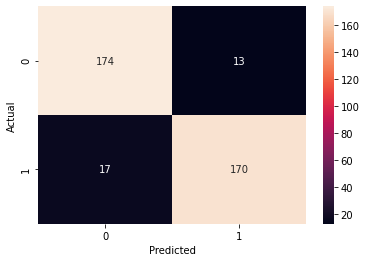

In [ ]:
# creating a graph out of confusion matrix
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [ ]:
# printing classification report
print(classification_report(y_test , y_pred))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       187
           1       0.93      0.91      0.92       187

    accuracy                           0.92       374
   macro avg       0.92      0.92      0.92       374
weighted avg       0.92      0.92      0.92       374



**Good Precesion And Recall Score, but can be improved**

# Model Prediction

- We will be predicting data on text coprus,
value > 5 is most likely be `spam`

In [ ]:
predict_text = [
                # Spam
                'We’d all like to get a $10,000 deposit on our bank accounts out of the blue, but winning a prize—especially if you’ve never entered a contest',
                'Netflix is sending you a refund of $12.99. Please reply with your bank account and routing number to verify and get your refund',
                'Your account is temporarily frozen. Please log in to to secure your account ',

                #ham
                'The article was published on 18th August itself',
                'Although we are unable to give you an exact time-frame at the moment, I would request you to stay tuned for any updates.',
                'The image you sent is a UI bug, I can check that your article is marked as regular and is not in the monetization program.'
]

In [ ]:
test_results = model.predict(predict_text)

In [ ]:
output = np.where(test_results>0.5,'spam', 'ham')

In [ ]:
output

array([['spam'],
       ['spam'],
       ['spam'],
       ['ham'],
       ['ham'],
       ['ham']], dtype='<U4')

# Additional Content

- Create a function which will take in `sentece array` and return the embedding vector for entire sentece -`pooled_output`
---
STEPS:
To do so inside the we follow 3 steps:

1. We `pass the sentence array to bert_preprocessor` as it can act a function point and name it **preprocessed_text**

2. Now we `pass this preprocessed sentence into encoder` and it return a embedding vector dictonary

3. We retun only the `pooled output` as we are interested in only the entire sentence encoding

---
Later we compare the embedding vector using `cosine - similarity from sklearn.metrics.parwiase` class


In [ ]:
def get_embedding(sentence_arr):
    'takes in sentence array and return embedding vector'
    preprocessed_text = bert_preprocessor(sentence_arr)
    embeddings = bert_encoder(preprocessed_text)['pooled_output']
    return embeddings

In [ ]:
e = get_embedding([
               'We’d all like to get a $10,000 deposit on our bank accounts out of the blue, but winning a prize—especially if you’ve never entered a contest',
               'The image you sent is a UI bug, I can check that your article is marked as regular and is not in the monetization program.'
])

In [ ]:
# load similartiy score
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# check similarity score
print(f'Similarity score between 1st sentence(spam) and second sentence(spam) : {cosine_similarity([e[0]] , [e[1]])}')

Similarity score between 1st sentence(spam) and second sentence(spam) : [[0.85391873]]


* Not exact similarity, may show un expected results as can be seen - they are somewhat similar but its false as spam and actual can't be same